In [2]:
import json
import multiprocessing
import os
import sys
from collections import defaultdict
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import mne
import numpy as np
from vr2f.staticinfo import COLORS, CONFIG, PATHS
from vr2f import helpers

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
def get_data(subID, picks="eeg"):
    paths = PATHS()
    path_in = Path(paths.DATA_03_AR, "cleaneddata")
    fname = Path(path_in, f"{subID}-postAR-epo.fif")
    epos = mne.read_epochs(fname, verbose=False).pick(picks)
    times = epos.times
    info = epos.info

    return epos, times, info

In [5]:
# load data
paths = PATHS()
config = CONFIG()
colors = COLORS()

In [6]:
path_in = Path(paths.DATA_03_AR, "cleaneddata")
sub_list_str = [s.split("-postAR-epo")[0] for s in os.listdir(path_in)]
epos = []
evos = []
for sub in sub_list_str:
    ee = get_data(sub)
    epos.append(ee)

In [7]:
emotions = ["happy", "angry", "neutral", "surprised"]

evos = defaultdict(dict)
evos_ga = defaultdict(dict)
for vc in ["stereo", "mono", ""]:
    for emo in emotions:
        evos[emo] = []
        for sub in epos:
            evos[emo].append(sub[0][emo].average())
        evos_ga[emo] = mne.grand_average(evos[emo])

        if vc == "":
            continue
        evos[vc][emo] = []
        for sub in epos:
            evos[vc][emo].append(sub[0][vc + "/" + emo].average())
        evos_ga[vc][emo] = mne.grand_average(evos[vc][emo])

ValueError: Please pass a list of Evoked or AverageTFR objects.

In [14]:
# calc differences to neutral for all emotions

evos_diff = defaultdict(dict)
evos_diff_ga = defaultdict(dict)
evos_diff_stereo_vs_mono = defaultdict(list)
for vc in ["stereo", "mono", ""]:
    for emo in emotions:
        evos_diff[emo] = []
        for sub in epos:
            evos_diff[emo].append(
                mne.combine_evoked([sub[0][emo].average(), sub[0]["neutral"].average()], weights=[1, -1])
            )
        evos_diff_ga[emo] = mne.grand_average(evos_diff[emo])

        if vc == "":
            continue
        evos_diff[vc][emo] = []
        for sub in epos:
            evos_diff[vc][emo].append(
                mne.combine_evoked(
                    [sub[0][vc + "/" + emo].average(), sub[0][vc + "/" + "neutral"].average()], weights=[1, -1]
                )
            )
        evos_diff_ga[vc][emo] = mne.grand_average(evos_diff[vc][emo])

for emo in emotions:
    for sub in epos:
        evos_diff_stereo_vs_mono[emo].append(
            mne.combine_evoked([sub[0]["mono/" + emo].average(), sub[0]["stereo/" + emo].average()], weights=[1, -1])
        )

Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


/tmp/ipykernel_10511/3995451425.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


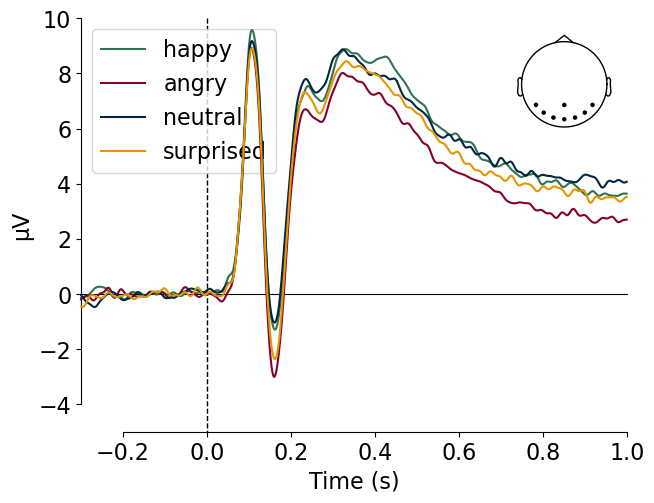

In [11]:
emotions = ["happy", "angry", "neutral", "surprised"]
cols = {c: colors.COLDICT[c] for c in emotions}

picks = dict()
picks["EPN"] = ["P7", "PO7", "Pz", "Oz", "O1", "P8", "PO8", "O2"]

cm = 1 / 2.54  # centimeters in inches
matplotlib.rcParams.update({"font.size": 16})

fig, ax = plt.subplots(1, 1, figsize=(16.5 * cm, 12.5 * cm))

p = mne.viz.plot_compare_evokeds(
    {emo: evos_ga[emo] for emo in emotions},
    picks=picks["EPN"],
    show=False,
    combine="mean",
    ylim=dict(eeg=[-5, 10]),
    title="",
    colors=cols,
    show_sensors="upper right",
    axes=ax,
)
fig.tight_layout()
fig.subplots_adjust(left=0.08, bottom=0.08, right=0.92, top=0.92)
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
matplotlib.rcParams["font.family"] = "Roboto"
fig.savefig(
    Path(paths.FIGURES, "erp_emo_all.pdf"),
    transparent=True,  # bbox_inches="tight"
)

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


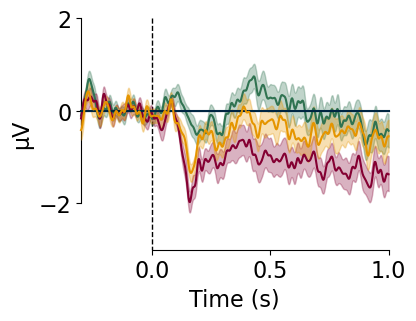

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(9.3 * cm, 7.0 * cm))

p = mne.viz.plot_compare_evokeds(
    {emo: evos_diff[emo] for emo in emotions},
    picks=picks["EPN"],
    show=False,
    combine="mean",
    ylim=dict(eeg=[-3, 2]),
    title="",
    colors={emo: colors.COLDICT[emo] for emo in emotions},
    legend=False,
    ci=0.68,
    axes=ax,
)
fig.tight_layout()
fig.subplots_adjust(left=0.08, bottom=0.08, right=0.92, top=0.92)
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
matplotlib.rcParams["font.family"] = "Roboto"
fig.savefig(
    Path(paths.FIGURES, "erp_emo-vs-neutral_all.pdf"),
    transparent=True,  # bbox_inches="tight"
)

combining channels using "mean"
combining channels using "mean"


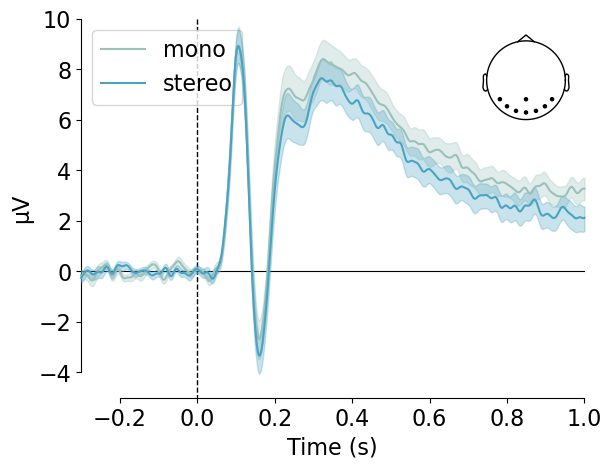

/tmp/ipykernel_37252/2357116436.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


In [60]:
emo_showcase = "angry"

fig, ax = plt.subplots(1, 1, figsize=(16.5 * cm, 12.5 * cm))

p = mne.viz.plot_compare_evokeds(
    {"mono": evos["mono"][emo_showcase], "stereo": evos["stereo"][emo_showcase]},
    picks=picks["EPN"],
    show=True,
    combine="mean",
    ylim=dict(eeg=[-5, 10]),
    title="",
    colors={vc: colors.COLDICT[vc] for vc in ["mono", "stereo"]},
    ci=0.68,
    show_sensors="upper right",
    axes=ax,
)

fig.tight_layout()
fig.subplots_adjust(left=0.08, bottom=0.08, right=0.92, top=0.92)
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
matplotlib.rcParams["font.family"] = "Roboto"
fig.savefig(
    Path(paths.FIGURES, "erp_angry_mono-vs-stereo.pdf"),
    transparent=True,  # bbox_inches="tight"
)

combining channels using "mean"
combining channels using "mean"


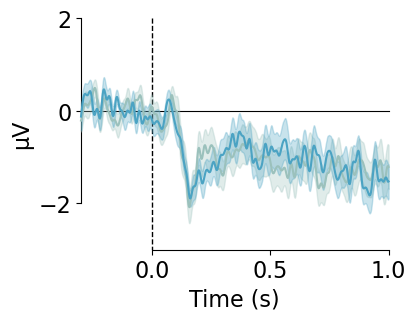

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(9.3 * cm, 7.0 * cm))

p = mne.viz.plot_compare_evokeds(
    {"mono": evos_diff["mono"][emo_showcase], "stereo": evos_diff["stereo"][emo_showcase]},
    picks=picks["EPN"],
    show=False,
    combine="mean",
    ylim=dict(eeg=[-3, 2]),
    title="",
    colors={vc: colors.COLDICT[vc] for vc in ["mono", "stereo"]},
    legend=False,
    ci=0.68,
    axes=ax,
)

fig.tight_layout()
fig.subplots_adjust(left=0.08, bottom=0.08, right=0.92, top=0.92)
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
matplotlib.rcParams["font.family"] = "Roboto"
fig.savefig(
    Path(paths.FIGURES, "erp_angry-vs-neutral_mono-vs-stereo.pdf"),
    transparent=True,  # bbox_inches="tight"
)

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


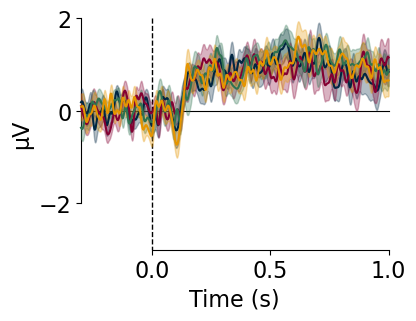

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(9.3 * cm, 7.0 * cm))

emos = ["neutral", "angry", "happy", "surprised"]

p = mne.viz.plot_compare_evokeds(
    {emo: evos_diff_stereo_vs_mono[emo] for emo in emos},
    picks=picks["EPN"],
    show=False,
    combine="mean",
    ylim=dict(eeg=[-3, 2]),
    title="",
    colors={emo: colors.COLDICT[emo] for emo in emos},
    legend=False,
    ci=0.68,
    axes=ax,
)

fig.tight_layout()
fig.subplots_adjust(left=0.08, bottom=0.08, right=0.92, top=0.92)
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
matplotlib.rcParams["font.family"] = "Roboto"
# fig.savefig(
#     Path(paths.FIGURES, f"erp_angry-vs-neutral_mono-vs-stereo.pdf"),
#     transparent=True,  # bbox_inches="tight"
# )

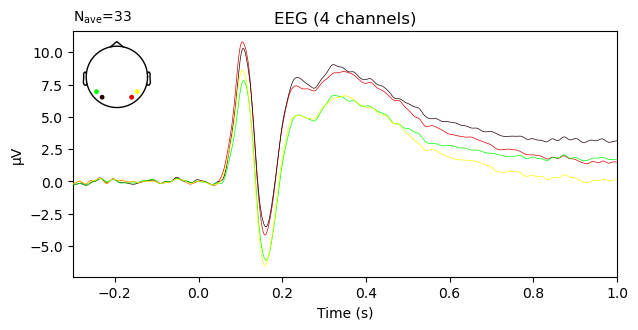

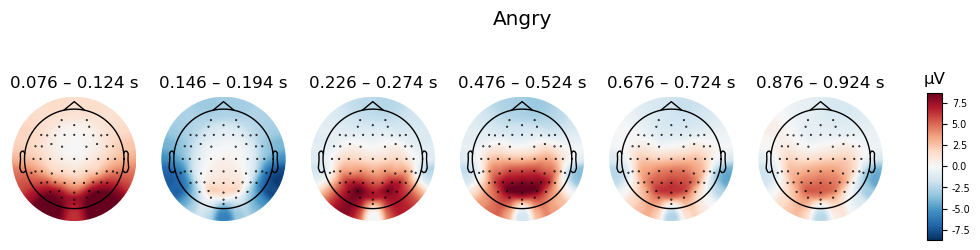

No projector specified for this dataset. Please consider the method self.add_proj.


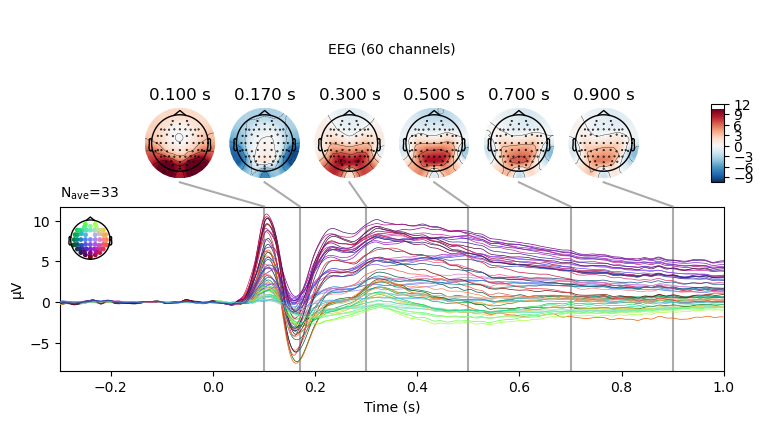

In [9]:
emo_target = "angry"
p = evos_ga[emo_target].plot(spatial_colors=True, gfp=False, time_unit="s", picks=["PO8", "PO7", "P7", "P8"])
P = evos_ga[emo_target].plot_topomap(
    times=[0.1, 0.170, 0.250, 0.5, 0.7, 0.9],
    time_unit="s",
    average=0.05,
    colorbar=True,
    outlines="skirt",
    contours=0,
    show_names=False,
    title="Angry",
)
p = evos_ga[emo_target].plot_joint(times=[0.1, 0.170, 0.300, 0.5, 0.7, 0.9])

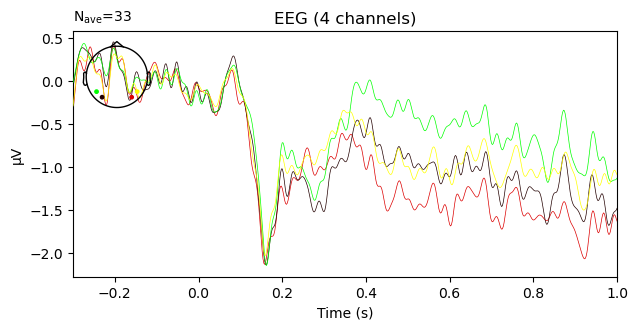

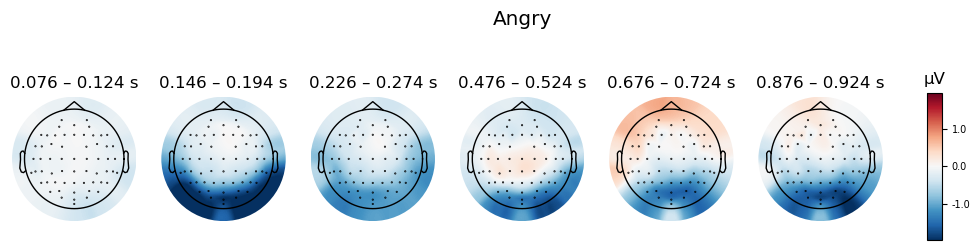

No projector specified for this dataset. Please consider the method self.add_proj.


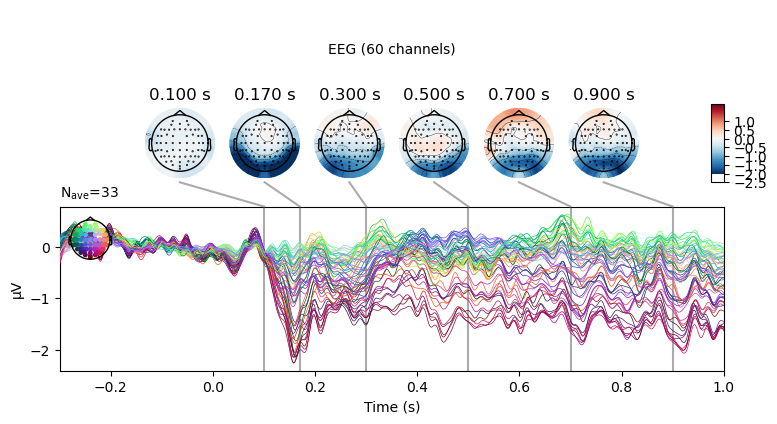

In [12]:
P = evos_diff_ga[emo_target].plot(spatial_colors=True, gfp=False, time_unit="s", picks=["PO8", "PO7", "P7", "P8"])
p = evos_diff_ga[emo_target].plot_topomap(
    times=[0.1, 0.170, 0.250, 0.5, 0.7, 0.9],
    time_unit="s",
    average=0.05,
    colorbar=True,
    outlines="skirt",
    contours=0,
    show_names=False,
    title="Angry",
)
p = evos_diff_ga[emo_target].plot_joint(times=[0.1, 0.170, 0.300, 0.5, 0.7, 0.9])

In [15]:
picks = ["Oz", "POz", "PO3", "PO4", "O1", "O2", "PO7", "PO8"]
# mne.viz.plot_compare_evokeds([evos["angry"], evos["neutral"]], show_sensors="upper right", combine='mean')

diff = mne.combine_evoked([evos["angry"], evos["neutral"]], weights=[1, -1])

AttributeError: 'list' object has no attribute 'nave'

In [88]:
view_conds = ["mono", "stereo"]
for vc in view_conds:
    evos[vc] = []
    for sub in epos:
        evos[vc].append(sub[0][vc][emo_showcase].average())

combining channels using "mean"
combining channels using "mean"


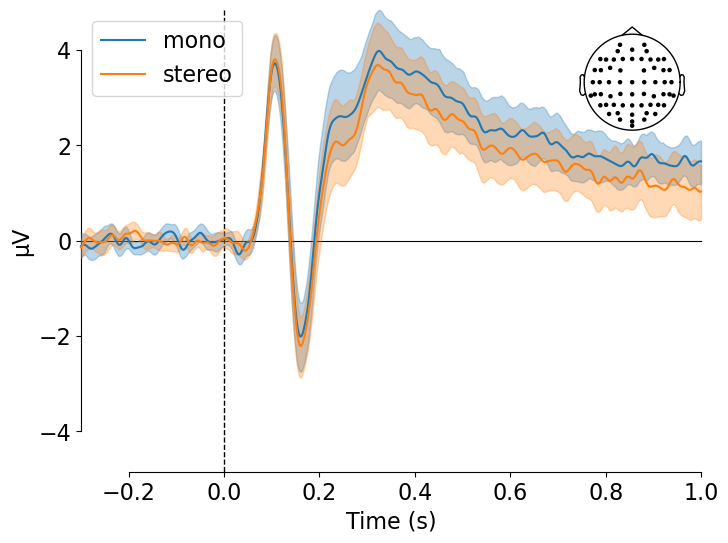

[<Figure size 800x600 with 2 Axes>]

In [91]:
evos_vc = {vc: evos[vc] for vc in view_conds}
mne.viz.plot_compare_evokeds(evos_vc, show_sensors="upper right", combine="mean", picks=picks["EPN"], ci=True)

In [93]:
e_m = mne.combine_evoked(evos_vc["mono"], weights="equal")
e_s = mne.combine_evoked(evos_vc["stereo"], weights="equal")

No projector specified for this dataset. Please consider the method self.add_proj.


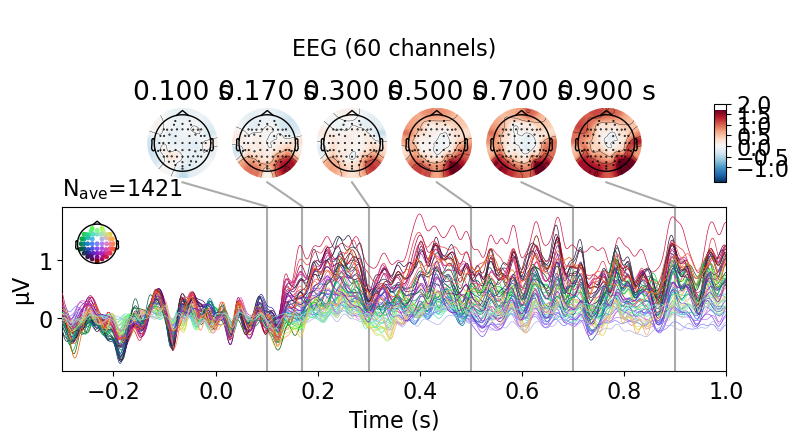

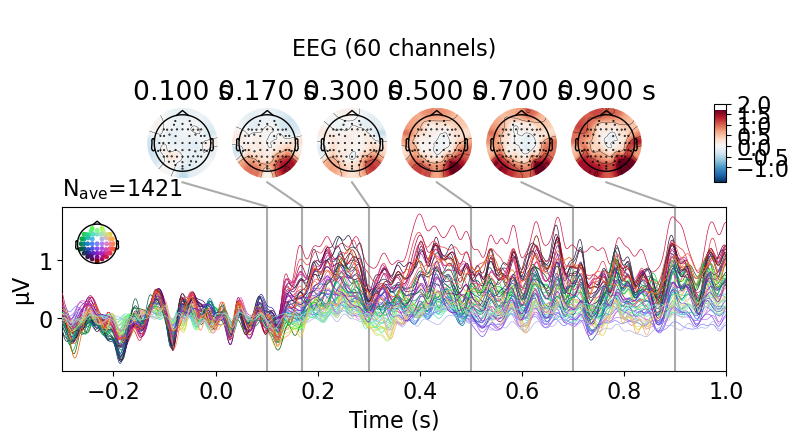

In [95]:
diff_vc = mne.combine_evoked([e_m, e_s], weights=[1, -1])
diff_vc.plot_joint(times=[0.1, 0.170, 0.300, 0.5, 0.7, 0.9])

In [76]:
evos_vc["mono"][0]

AttributeError: 'EvokedArray' object has no attribute 'average'